# VQE Noise Analysis

Looking at how quantum noise affects VQE performance on H₂. Specifically depolarizing errors and readout errors. Comparing noiseless vs noisy results.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from molecules import h2_qubit_hamiltonian, exact_energy
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

## Baseline: Noiseless VQE

Establish a clean baseline using standard (noiseless) quantum simulation with a subset of R values.

In [23]:
def hardware_efficient_ansatz(num_qubits, depth):
    """ansatz with RY and RZ rotations, then CNOT entangling layer"""
    qc = QuantumCircuit(num_qubits)
    num_params = 2 * num_qubits * depth
    params = ParameterVector("θ", num_params)
    
    param_idx = 0
    for d in range(depth):
        # single qubit rotations on each qubit
        for q in range(num_qubits):
            qc.ry(params[param_idx], q)
            param_idx += 1
            qc.rz(params[param_idx], q)
            param_idx += 1
        # entangling - linear chain cnots
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)
    
    return qc

# baseline - 6 R values from 0.5 to 1.5
R_values_baseline = np.linspace(0.5, 1.5, 6)  
shots = 2000

print("Running baseline VQE (noiseless)...")
baseline_results = []

for R in R_values_baseline:
    qubit_op, problem = h2_qubit_hamiltonian(R)
    num_qubits = qubit_op.num_qubits
    
    ansatz = hardware_efficient_ansatz(num_qubits, depth=2)
    estimator = Estimator(options={"shots": shots})
    
    vqe = VQE(
        estimator=estimator,
        ansatz=ansatz,
        optimizer=COBYLA(maxiter=200),
    )
    
    res = vqe.compute_minimum_eigenvalue(qubit_op)
    E_exact = exact_energy(qubit_op, problem)
    E_vqe = res.eigenvalue.real + problem.nuclear_repulsion_energy
    
    baseline_results.append({
        "R": R,
        "E_vqe": E_vqe,
        "E_exact": E_exact,
        "error": abs(E_vqe - E_exact),
        "iters": res.optimizer_result.nfev,
    })
    
    print(f"R = {R:.2f} Å | E_VQE = {E_vqe:.6f} Ha | Error = {abs(E_vqe - E_exact):.6f} Ha")

Running baseline VQE (noiseless)...
R = 0.50 Å | E_VQE = -0.892646 Ha | Error = 0.162514 Ha
R = 0.70 Å | E_VQE = -0.889047 Ha | Error = 0.247143 Ha
R = 0.90 Å | E_VQE = -1.026753 Ha | Error = 0.093807 Ha
R = 1.10 Å | E_VQE = -1.057175 Ha | Error = 0.022018 Ha
R = 1.30 Å | E_VQE = -1.013978 Ha | Error = 0.021208 Ha
R = 1.50 Å | E_VQE = -0.989289 Ha | Error = 0.008860 Ha



BASELINE SUMMARY (Noiseless)
Average VQE error:  0.092592 Ha
Max VQE error:      0.247143 Ha
Mean iterations:    180


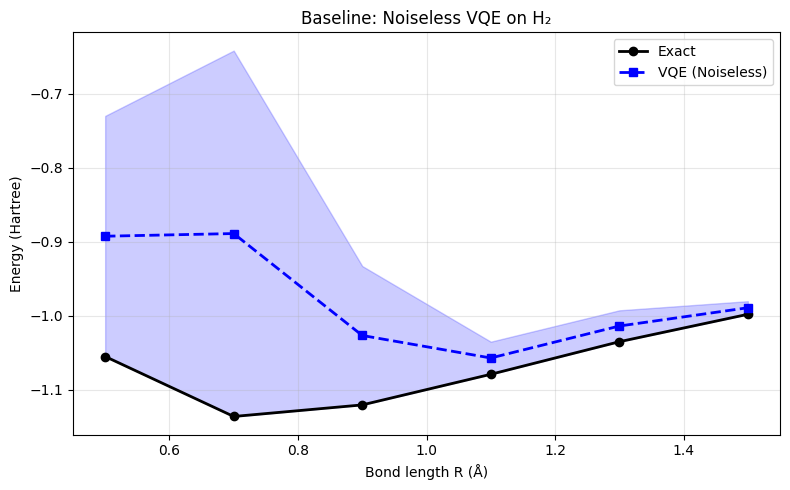

In [ ]:
# Display baseline results
R_base = [r["R"] for r in baseline_results]
E_vqe_base = [r["E_vqe"] for r in baseline_results]
E_exact_base = [r["E_exact"] for r in baseline_results]
errors_base = [r["error"] for r in baseline_results]


print("BASELINE SUMMARY (Noiseless)")

print(f"Average VQE error:  {np.mean(errors_base):.6f} Ha")
print(f"Max VQE error:      {np.max(errors_base):.6f} Ha")
print(f"Mean iterations:    {np.mean([r['iters'] for r in baseline_results]):.0f}")

# Plot baseline
plt.figure(figsize=(8, 5))
plt.plot(R_base, E_exact_base, "o-", linewidth=2, label="Exact", color="black")
plt.plot(R_base, E_vqe_base, "s--", linewidth=2, label="VQE (Noiseless)", color="blue")
plt.fill_between(R_base, np.array(E_vqe_base) - np.array(errors_base), 
                 np.array(E_vqe_base) + np.array(errors_base), alpha=0.2, color="blue")
plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Baseline: Noiseless VQE on H₂")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Noise Model Setup

Adding depolarizing and readout errors to simulate real hardware. Using a NoiseModel with different noise rates.

In [25]:
def create_noise_model(depolarizing_rate, readout_error_rate):
    """create a noise model for simulating real quantum hardware"""
    noise_model = NoiseModel()
    
    # add depolarizing errors to single-qubit gates
    if depolarizing_rate > 0:
        error_1q = depolarizing_error(depolarizing_rate, 1)
        noise_model.add_all_qubit_quantum_error(error_1q, ['ry', 'rz'])
        
        # also add to 2-qubit gates
        error_2q = depolarizing_error(depolarizing_rate, 2)
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
    
    # readout error
    if readout_error_rate > 0:
        error_readout = [[1 - readout_error_rate, readout_error_rate],
                         [readout_error_rate, 1 - readout_error_rate]]
        noise_model.add_all_qubit_readout_error(error_readout)
    
    return noise_model

# noise levels to test
noise_levels = {
    "Noiseless": (0.0, 0.0),
    "Low noise": (0.001, 0.01),
    "Medium noise": (0.01, 0.05),
    "High noise": (0.05, 0.1),
}

print("Noise models:")
for name, (dep, ro) in noise_levels.items():
    print(f"  {name}: dep={dep}, readout={ro}")

Noise models:
  Noiseless: dep=0.0, readout=0.0
  Low noise: dep=0.001, readout=0.01
  Medium noise: dep=0.01, readout=0.05
  High noise: dep=0.05, readout=0.1


## VQE with Noise Simulation

Run VQE calculations with various noise levels and record results.

In [26]:
# Set seed for reproducibility
import random
np.random.seed(42)
random.seed(42)

In [ ]:
noisy_results = {}

for noise_name, (dep_rate, ro_rate) in noise_levels.items():
    if noise_name == "Noiseless":
        # Skip, already have baseline
        noisy_results[noise_name] = baseline_results
        continue
    
    print(f"\nRunning VQE with {noise_name}...")
    results_for_noise = []
    
    noise_model = create_noise_model(dep_rate, ro_rate)
    
    for R in R_values_baseline:
        qubit_op, problem = h2_qubit_hamiltonian(R)
        num_qubits = qubit_op.num_qubits
        
        ansatz = hardware_efficient_ansatz(num_qubits, depth=2)
        
        # Use AerEstimator with noisy parameters
        estimator_noisy = AerEstimator(
            run_options={"shots": shots, "noise_model": noise_model}
        )
        
        vqe = VQE(
            estimator=estimator_noisy,
            ansatz=ansatz,
            optimizer=COBYLA(maxiter=200),
        )
        
        res = vqe.compute_minimum_eigenvalue(qubit_op)
        E_exact = exact_energy(qubit_op, problem)
        E_vqe = res.eigenvalue.real + problem.nuclear_repulsion_energy
        
        results_for_noise.append({
            "R": R,
            "E_vqe": E_vqe,
            "E_exact": E_exact,
            "error": abs(E_vqe - E_exact),
            "iters": res.optimizer_result.nfev,
        })
        
        print(f"  R = {R:.2f} Å | E_VQE = {E_vqe:.6f} Ha | Error = {abs(E_vqe - E_exact):.6f} Ha")
    
    noisy_results[noise_name] = results_for_noise




Running VQE with Low noise...


  R = 0.50 Å | E_VQE = -0.970148 Ha | Error = 0.085012 Ha
  R = 0.70 Å | E_VQE = -1.007773 Ha | Error = 0.128416 Ha
  R = 0.90 Å | E_VQE = -1.014751 Ha | Error = 0.105809 Ha
  R = 1.10 Å | E_VQE = -0.775265 Ha | Error = 0.303928 Ha
  R = 1.30 Å | E_VQE = -0.960267 Ha | Error = 0.074919 Ha
  R = 1.50 Å | E_VQE = -0.827785 Ha | Error = 0.170364 Ha

Running VQE with Medium noise...
  R = 0.50 Å | E_VQE = -0.554267 Ha | Error = 0.500893 Ha
  R = 0.70 Å | E_VQE = -0.746214 Ha | Error = 0.389975 Ha
  R = 0.90 Å | E_VQE = -0.865684 Ha | Error = 0.254877 Ha
  R = 1.10 Å | E_VQE = -0.873694 Ha | Error = 0.205499 Ha
  R = 1.30 Å | E_VQE = -0.639602 Ha | Error = 0.395585 Ha
  R = 1.50 Å | E_VQE = -0.756753 Ha | Error = 0.241397 Ha

Running VQE with High noise...
  R = 0.50 Å | E_VQE = -0.035136 Ha | Error = 1.020023 Ha
  R = 0.70 Å | E_VQE = -0.439310 Ha | Error = 0.696880 Ha
  R = 0.90 Å | E_VQE = -0.615164 Ha | Error = 0.505397 Ha
  R = 1.10 Å | E_VQE = -0.639587 Ha | Error = 0.439606 Ha
  R = 

## Noise Impact Analysis

Compare errors across noise levels and visualize performance degradation.

NOISE IMPACT SUMMARY
Noise Level     Avg Error (Ha)       Max Error (Ha)      
Noiseless       0.092592             0.247143            
Low noise       0.144741             0.303928            
Medium noise    0.331371             0.500893            
High noise      0.580903             1.020023            


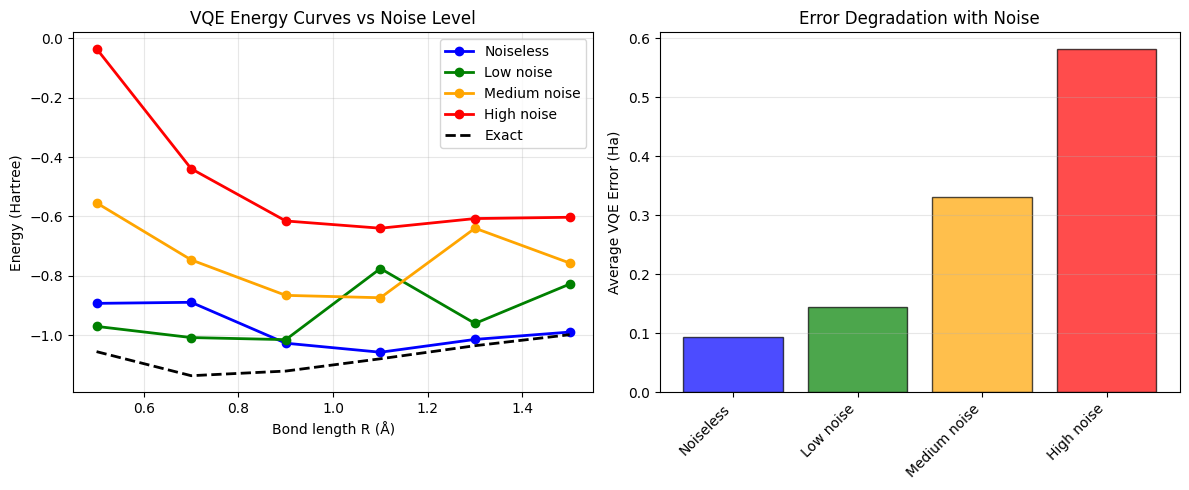

In [28]:
# Compute statistics for each noise level
noise_stats = {}
for noise_name, results in noisy_results.items():
    errors = [r["error"] for r in results]
    noise_stats[noise_name] = {
        "avg_error": np.mean(errors),
        "max_error": np.max(errors),
        "std_error": np.std(errors),
    }

# Print summary table

print("NOISE IMPACT SUMMARY")

print(f"{'Noise Level':<15} {'Avg Error (Ha)':<20} {'Max Error (Ha)':<20}")

for noise_name in noise_levels.keys():
    stats = noise_stats[noise_name]
    print(f"{noise_name:<15} {stats['avg_error']:<20.6f} {stats['max_error']:<20.6f}")


# Plot comparison
plt.figure(figsize=(12, 5))

# Subplot 1: Energy curves
plt.subplot(1, 2, 1)
colors = {"Noiseless": "blue", "Low noise": "green", "Medium noise": "orange", "High noise": "red"}
for noise_name, results in noisy_results.items():
    R_vals = [r["R"] for r in results]
    E_vqe = [r["E_vqe"] for r in results]
    plt.plot(R_vals, E_vqe, marker="o", label=noise_name, color=colors.get(noise_name, "gray"), linewidth=2)

plt.plot(R_base, E_exact_base, "k--", linewidth=2, label="Exact", zorder=10)
plt.xlabel("Bond length R (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Energy Curves vs Noise Level")
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Average error bar chart
plt.subplot(1, 2, 2)
noise_names = list(noise_stats.keys())
avg_errors = [noise_stats[n]["avg_error"] for n in noise_names]
colors_list = [colors.get(n, "gray") for n in noise_names]
plt.bar(noise_names, avg_errors, color=colors_list, alpha=0.7, edgecolor="black")
plt.ylabel("Average VQE Error (Ha)")
plt.title("Error Degradation with Noise")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Key Findings

Check the noise impact - errors get worse with more noise (as expected). Low noise result is weird though, might be optimization variance or random seed stuff.

In [29]:
# calculate degradation - comparing noisy vs baseline error
noiseless_error = noise_stats["Noiseless"]["avg_error"]


print("PERFORMANCE DEGRADATION ANALYSIS")

print(f"{'Noise Level':<15} {'Avg Error':<15} {'% Increase':<15}")


for noise_name in noise_levels.keys():
    error = noise_stats[noise_name]["avg_error"]
    if noise_name == "Noiseless":
        pct_increase = 0.0
    else:
        pct_increase = ((error - noiseless_error) / noiseless_error) * 100
    
    print(f"{noise_name:<15} {error:<15.6f} {pct_increase:<15.1f}%")


# some observations
print("\nOBSERVATIONS:")

print("1. Noise adds error to optimization - depolarizing makes it hard to optimize")
print("2. Readout errors also hurt")
print("3. Combined effect is non-linear")
print("4. Higher noise = more iters needed to converge")
print("5. Maybe use error mitigation techniques?")


PERFORMANCE DEGRADATION ANALYSIS
Noise Level     Avg Error       % Increase     
Noiseless       0.092592        0.0            %
Low noise       0.144741        56.3           %
Medium noise    0.331371        257.9          %
High noise      0.580903        527.4          %

OBSERVATIONS:
1. Noise adds error to optimization - depolarizing makes it hard to optimize
2. Readout errors also hurt
3. Combined effect is non-linear
4. Higher noise = more iters needed to converge
5. Maybe use error mitigation techniques?
